## MACHINE LEARNING ASSET ALLOCATION WITH BRAZILIAN STOCKS 

In [1]:
%load_ext autoreload
%autoreload 2  

import numpy as np
import pandas as pd
import yfinance as yf
# from pandas_datareader import data as pdr
import functions as f
import matplotlib.pyplot as plt
import datetime as dt
import functions as f

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import HRPOpt

### Import Data

In [11]:
acoes = f.tickers(['petr4', 'vale3', 'bbdc4', 'itub4', 'mglu3', 'cple6', 'GGBR4','WEGE3','ABEV3','B3SA3'])
# acoes = f.tickers('tickers.txt')
stock_prices = f.download_portfolio(acoes, start='2013-01-01' , end='2022-12-31' , fill=True, drop=False)
rets = f.returns(stock_prices); rets.shape

[*********************100%***********************]  10 of 10 completed


(119, 10)

In [16]:
rets

,ABEV3.SA,B3SA3.SA,BBDC4.SA,CPLE6.SA,GGBR4.SA,ITUB4.SA,MGLU3.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Date,,,,,,,,,,
2013-02-01,-0.030425,-0.038020,-0.034501,-0.095385,-0.058386,0.021431,-0.155000,-0.081305,-0.061103,0.048693
2013-03-01,-0.054427,0.005966,0.040741,0.048276,-0.065653,0.011855,-0.122288,0.108970,-0.070635,-0.009108
2013-04-01,-0.001465,0.026686,-0.010914,0.163158,0.017558,-0.039600,-0.195505,0.090662,-0.023911,0.009423
2013-05-01,0.003056,0.027697,0.042424,-0.065703,-0.164532,0.058617,0.138266,0.017754,-0.088257,0.080122
2013-06-01,0.010116,-0.103295,-0.162091,-0.146454,-0.036127,-0.111711,-0.339876,-0.193918,-0.050575,-0.005652
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.022773,0.068530,0.088972,-0.002861,-0.046607,0.093569,0.655039,-0.026940,-0.075269,0.014094
2022-09-01,0.017682,0.101266,0.047557,-0.055954,0.077768,0.100356,0.049180,0.101304,0.174789,0.136090
2022-10-01,0.029601,0.159641,0.002002,0.124620,0.053601,0.084134,-0.002232,0.000336,-0.068157,0.255078


In [17]:
stock_rets

[]

In [12]:
retornos = []
periodos = 12

for i, month in enumerate(stock_prices.index):
    if stock_prices[(i+periodos) : (i+periodos+1)].shape[0] == 1:
        train_df = stock_prices[(i) : (i+periodos)]
        oot_df = stock_prices[(i+periodos) : (i+periodos+2)].pct_change().dropna() ## to pulando 1 mes pra não rolar DATA LEAKAGE
        
        hrp = HRPOpt(train_df)
        hrp.optimize()
        pesos_hrp = np.array(list(hrp.clean_weights().values()))
        pesos_df = pd.DataFrame(data={'pesos':pesos_hrp}, index=oot_df.columns).sort_values(by='pesos', ascending=False).T
        
        stock_rets = []
        for n, date in enumerate(oot_df.index):
            for stock in oot_df.columns:
                retorno_mes = oot_df[stock][n] * pesos_df[stock][n]
                stock_rets.append(retorno_mes)
        indice = oot_df.index
        
        
        print(f'Periodo de Treino: {train_df.index.min()} até {train_df.index.max()}\n\
Periodo de Validação {oot_df.index} \n {pesos_df*100} \n ----- \n') ## ULTIMO MÊS NÂO VAI TER PERIODO DE VALIDAÇÃO, POR QUE É O MÊS "ATUAL" 
    
    
    
    else:
        break
    
retornos.append(sum(stock_rets)) 

Periodo de Treino: 2013-01-01 00:00:00 até 2013-12-01 00:00:00
Periodo de Validação DatetimeIndex(['2014-02-01'], dtype='datetime64[ns]', name='Date', freq=None) 
        MGLU3.SA  CPLE6.SA  B3SA3.SA  WEGE3.SA  ABEV3.SA  PETR4.SA  ITUB4.SA  \
pesos     64.04    22.229     5.608     3.848      2.03     0.805     0.776   

       BBDC4.SA  GGBR4.SA  VALE3.SA  
pesos     0.547     0.076     0.041   
 ----- 

Periodo de Treino: 2013-02-01 00:00:00 até 2014-01-01 00:00:00
Periodo de Validação DatetimeIndex(['2014-03-01'], dtype='datetime64[ns]', name='Date', freq=None) 
        MGLU3.SA  CPLE6.SA  WEGE3.SA  B3SA3.SA  ABEV3.SA  ITUB4.SA  BBDC4.SA  \
pesos    84.106    10.242     1.949     1.678     0.968     0.332     0.313   

       PETR4.SA  GGBR4.SA  VALE3.SA  
pesos     0.278     0.073      0.06   
 ----- 

Periodo de Treino: 2013-03-01 00:00:00 até 2014-02-01 00:00:00
Periodo de Validação DatetimeIndex(['2014-04-01'], dtype='datetime64[ns]', name='Date', freq=None) 
        MGLU3.SA  C

c:\Users\pedro\Documents\ml-asset-allocation\functions.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  return ann_ex_ret/ann_vol
c:\Users\pedro\Documents\ml-asset-allocation\functions.py:21: RuntimeWarning: invalid value encountered in scalar divide
  return exp/sigma_r**3
c:\Users\pedro\Documents\ml-asset-allocation\functions.py:34: RuntimeWarning: invalid value encountered in scalar divide
  return exp/sigma_r**4
c:\Users\pedro\Documents\ml-asset-allocation\functions.py:21: RuntimeWarning: invalid value encountered in scalar divide
  return exp/sigma_r**3
c:\Users\pedro\Documents\ml-asset-allocation\functions.py:34: RuntimeWarning: invalid value encountered in scalar divide
  return exp/sigma_r**4


,Annualized Return,Annualized Vol,Sharpe Ratio,Average Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Max Drawdown
retornos,0.0,0.0,-inf,0.0,NaN,NaN,NaN,-0.0,0.0


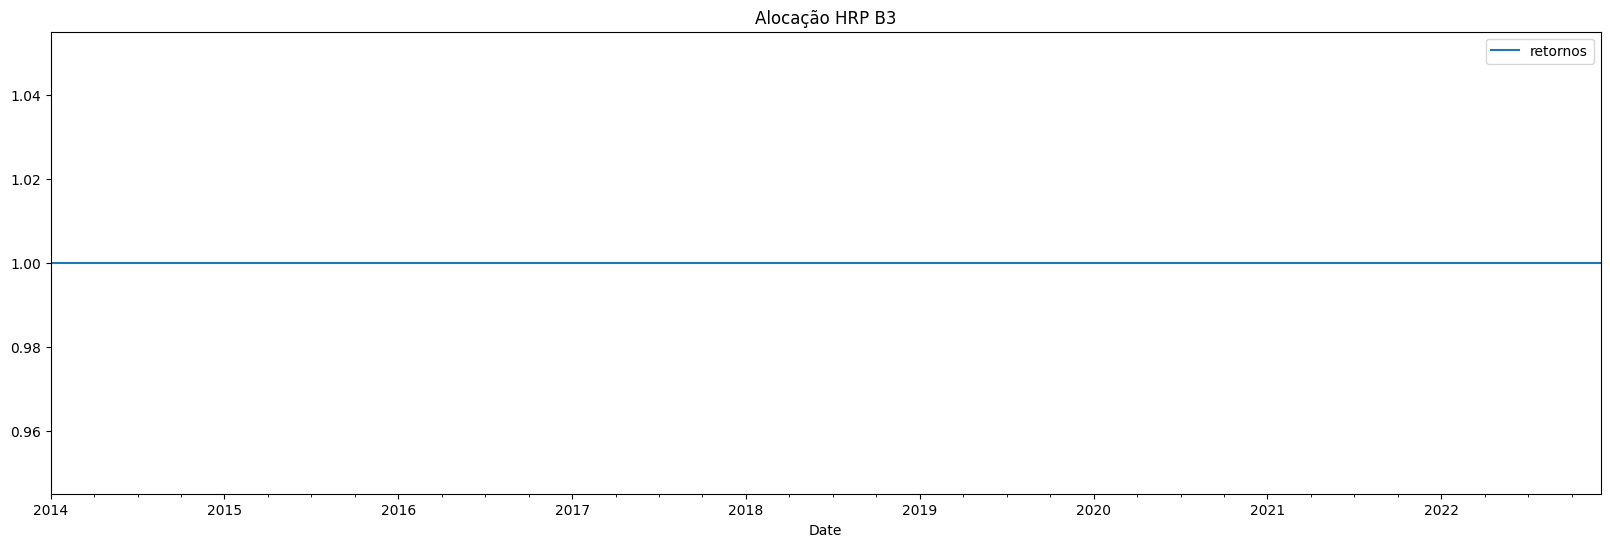

In [13]:
data=stock_prices.index[periodos:]
hrp_rets = pd.DataFrame({'retornos':retornos}, index=data);hrp_rets
hrp_rets_plot = (1+hrp_rets).cumprod();hrp_rets_plot*100
hrp_rets_plot.plot(figsize=(20,6), title="Alocação HRP B3");
f.summary_stats(hrp_rets, .12)

,Annualized Return,Annualized Vol,Sharpe Ratio,Average Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Max Drawdown
rets,0.232814,0.271284,0.373595,-0.082064,0.180985,5.59796,0.099478,0.138428,-0.428833


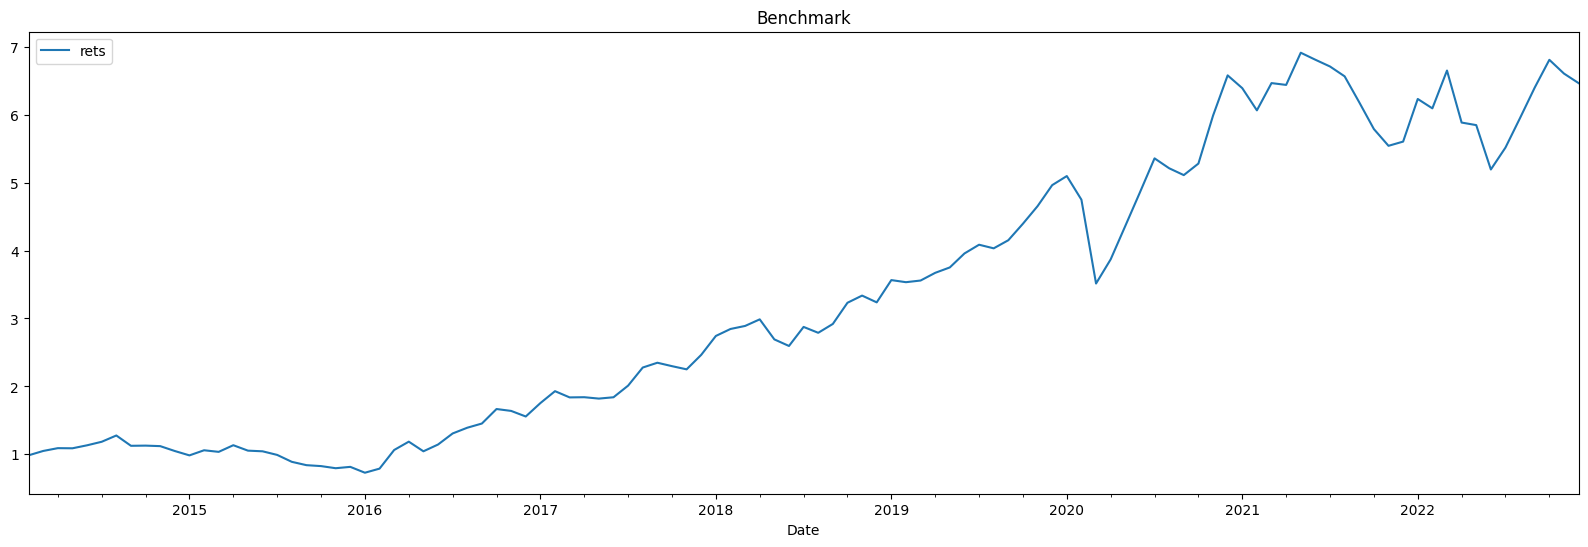

In [14]:
bm_rets = pd.DataFrame({'rets':f.backtest_ws(rets, 12)}).dropna(axis='rows')
bm = (1+bm_rets).cumprod()
bm.plot(figsize=(20,6), title="Benchmark");
f.summary_stats(pd.DataFrame(bm_rets['rets']), .12)


In [ ]:
f.underwater_plot(hrp_rets['retornos'], figsize=(20,6))

In [ ]:
f.plot_rets_distribuition(hrp_rets['retornos'], figsize=(8,5));